<a href="https://colab.research.google.com/github/janpeter19/BPL_YEAST_COB_Batch/blob/main/BPL_YEAST_COB_Batch_fmpy_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BPL_TEST2_Batch script with FMPy

The key library FMPy is installed.

After the installation a small application BPL_YEAST_COB_Batch is loaded and run. You can continue with this example if you like.

In [1]:
!lsb_release -a # Actual VM Ubuntu version used by Google

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.4 LTS
Release:	22.04
Codename:	jammy


In [2]:
!python --version

Python 3.11.11


In [3]:
!pip install fmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 3.4 MB/s eta 0:00:00


In [4]:
# For some reason conda installation does not work for optlang
!pip install optlang

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.3 MB/s eta 0:00:00


# BPL_YEAST_COB_Batch setup


Now specific installation and the run simulations. Start with connecting to Github. Then upload the two files:

* FMU - BPL_YEAST_COB_Batch_linux_om_me.fmu
* Setup-file - BPL_YEAST_COB_Batch_fmpy_explore.py

In [5]:
%%bash
git clone https://github.com/janpeter19/BPL_YEAST_COB_Batch

Cloning into 'BPL_YEAST_COB_Batch'...


In [6]:
%cd BPL_YEAST_COB_Batch

/content/BPL_YEAST_COB_Batch


In [7]:
run -i BPL_YEAST_COB_Batch_fmpy_explore.py

Linux - run FMU pre-comiled OpenModelica

Model for bioreactor has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values/units

Note that both disp() and describe() takes values from the last simulation
and the command process_diagram() brings up the main configuration

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [8]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [25/2.54, 20/2.54]

In [9]:
import warnings
warnings.filterwarnings("ignore")

## BPL_YEAST_COB_Batch - demo



In [10]:
from optlang import Model, Variable, Constraint, Objective

No processDiagram.png file in the FMU, but try the file on disk.


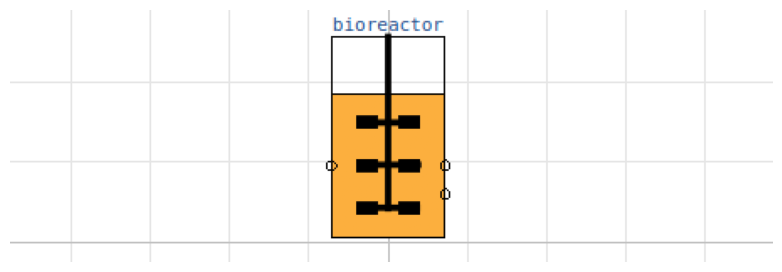

In [11]:
process_diagram()

In [12]:
describe('culture'); print(); #describe('liquidphase')                                  # Pump schedule parameter


Saccharomyces cerevisae - default parameters for strain H1022



In [13]:
# Define culture constraint-based model
def culture(G, E):

    # LP calculation of the optimal qGr, qEr based on G and E values

    # - parameters
    qO2max = 6.9e-3; kog = 2.3; koe = 1.6; YGr = 3.5; YEr = 1.32;
    alpha = 0.01; beta = 1.0

    # - transfer data from dynamic reactor model to static LP model
    qGr_opt = Variable('qGr_opt', lb=0)
    qEr_opt = Variable('qEr_opt', lb=0)

    # - LP model constraint and objective
    mu_max = Objective(YGr*qGr_opt + YEr*qEr_opt, direction='max')
    qO2lim = Constraint(kog*qGr_opt + koe*qEr_opt, ub=qO2max)
    qGlim = Constraint(qGr_opt, ub=alpha*max(0,G))
    qElim = Constraint(qEr_opt, ub=beta*max(0,E))

    # - put together the LP model
    yeast_model = Model(name='Yeast bottleneck model')
    yeast_model.objective = mu_max
    yeast_model.add(qO2lim)
    yeast_model.add(qGlim)
    yeast_model.add(qElim)

    # - do LP optimization
    yeast_model.optimize()

    return (yeast_model.objective.value, yeast_model.variables.qGr_opt.primal, yeast_model.variables.qEr_opt.primal, qO2lim.primal)

In [14]:
# Initialization
V_start=1.0
init(V_start=V_start, VX_start=V_start*2.0, VG_start=V_start*10, VE_start=V_start*3.0)

In [15]:
# Loop of simulations
t_final = 8.0
t_samp = 0.0333
n_samp = t_final/t_samp + 1

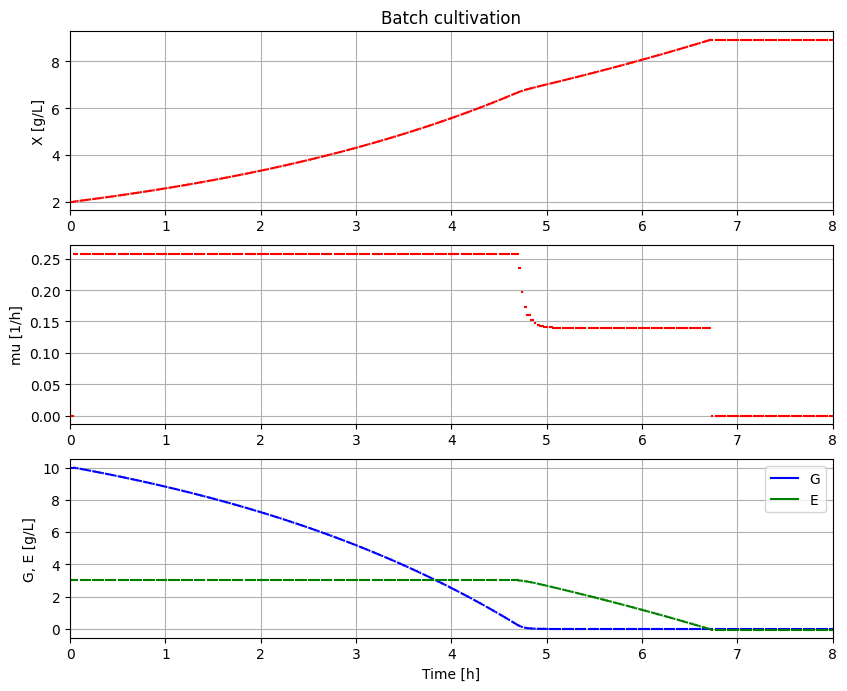

In [16]:
# Simulate n sample steps
newplot(title='Batch cultivation', plotType='TimeSeries2')
ax1.set_xlim([0, t_final]); ax2.set_xlim([0, t_final]); ax3.set_xlim([0, t_final])

simu(t_samp, options=opts_fast)
for i in range(int(n_samp)):
    (mum_opt, qGr_opt, qEr_opt, qO2_opt) = culture(sim_res['bioreactor.c[2]'][-1], sim_res['bioreactor.c[3]'][-1])
    par(mum=mum_opt, qGr=qGr_opt, qEr=qEr_opt, qO2=qO2_opt)
    simu(t_samp, 'cont', options=opts_fast)

In [17]:
system_info()


System information
 -OS: Linux
 -Python: 3.11.11
 -Scipy: not installed in the notebook
 -FMPy: 0.3.22
 -FMU by: OpenModelica Compiler OpenModelica 1.25.0~dev-133-ga5470be
 -FMI: 2.0
 -Type: ME
 -Name: BPL_YEAST_COB.Batch
 -Generated: 2024-11-08T08:21:20Z
 -MSL: 3.2.3
 -Description: Bioprocess Library version 2.3.0
 -Interaction: FMU-explore for FMPy version 1.0.1
